# Recommendations with IBM


## Introduction

For this project we will analyze the interactions that users have with articles on the IBM Watson Studio platform, and make recommendations to them with new articles.
 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [1]:
# Install progressbar
! pip install progressbar

You should consider upgrading via the 'c:\users\ankit\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import project_tests as t
import pickle
import progressbar
from sklearn.metrics import accuracy_score
%matplotlib inline

In [3]:
#import data
df = pd.read_csv(r'D:\Data Science Projects\Udacity\recommendation\exercise project\user-item-interactions.csv')
df_content = pd.read_csv(r'D:\Data Science Projects\Udacity\recommendation\exercise project\articles_community.csv')

# Show df to get an idea of the data
display(df.head())

# Show df_content to get an idea of the data
display(df_content.head())

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
#delete 'Unnamed: 0' column
del df['Unnamed: 0']
del df_content['Unnamed: 0']

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


1. Explore distribution of Number of articles a user interacts with in the dataset

In [7]:
# articles per user
articles_per_user = df.groupby(["email"]).count()["article_id"].sort_values(ascending=False)
articles_per_user.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

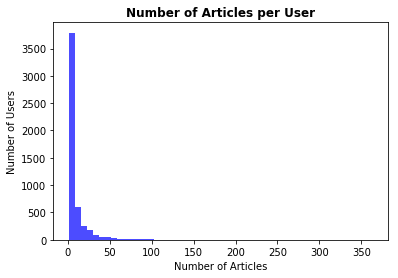

In [8]:
# plot of Number of Articles per User distribution
num_bins = 50
n, bins, patches = plt.hist(articles_per_user, num_bins,                                
                            color ='blue', 
                            alpha = 0.7) 
  
plt.xlabel('Number of Articles') 
plt.ylabel('Number of Users') 
plt.title("Number of Articles per User", fontweight ="bold") 
  
plt.show() 

In [9]:
#median_val
median_val = articles_per_user.median()
print(median_val)

3.0


In [10]:
#max_views_by_user
max_views_by_user = articles_per_user.max()
print(max_views_by_user)

364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles

# duplicated rows in df_content
df_content.duplicated().sum()

0

In [12]:
# check missing values
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [13]:
# exploring data with respect to duplicate article_ids in df_content
df_content[df_content["article_id"].
           isin(list(df_content["article_id"][df_content["article_id"].duplicated()]))]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [14]:
# Remove any rows that have the same article_id - only keep the first
duplicate_articleid_rows = df_content["article_id"].duplicated()
if True in duplicate_articleid_rows:
    df_content = df_content[~duplicate_articleid_rows]

In [15]:
# Confirming number of duplicate article ids
df_content["article_id"].duplicated().sum()

0

`3.` Explore and remove duplicate articles from the **df** dataframe.

In [16]:
# shape of df
print("df shape:",df.shape)

# duplicates in df
print("df duplicates:",df.duplicated().sum()) # these duplicates are user item interactions, these should not be removed.

df shape: (45993, 3)
df duplicates: 12311


In [17]:
# Missing values in df
print("df missing values:",df.isnull().sum())

df missing values: article_id     0
title          0
email         17
dtype: int64


In [18]:
# The number of unique articles that have at least one interaction
unique_articles = (df["article_id"]).nunique()
print(unique_articles)

714


In [19]:
# The number of unique articles on the IBM platform
total_articles = df_content["article_id"].nunique()
print(total_articles)

1051


In [20]:
# The number of unique users
unique_users = df["email"].nunique()
print(unique_users)

5148


In [21]:
# The number of user-article interactions
user_article_interactions = df.shape[0]
print(user_article_interactions)

45993


In [22]:
# most viewed article_id
df.groupby(["article_id"]).count()["email"].sort_values(ascending = False).head(1)

article_id
1429.0    937
Name: email, dtype: int64

In [23]:
most_viewed_article_id = '1429.0'     
max_views = 937

In [24]:
# Assign unique user_Id to unique email in df dataframe

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In the given dataset, only information available is whether a user has interacted with an article. Therefore, the popularity of an article can only be based on how often an article was interacted with.


`1.` Get **n** top articles ordered with most interactions as the top

In [25]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(["title"]).count()["user_id"]
                        .sort_values(ascending = False).head(n).index)
    
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(["article_id"]).count()["user_id"]
                        .sort_values(ascending = False).head(n).index)
 
    return top_articles # Return the top article ids

In [26]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Create the user-article matrix by reformating the **df** dataframe to be shaped with users as the rows and articles as the columns.  

In [27]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id',
                            'article_id'])['title'].agg(lambda x: 1).unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
print(user_item.head())

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3              0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
4              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

article_id  16.0    18.0     ...    1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                      ...                                             
1              0.0     0.0   ...       0.0     0.0     1.0     0.0     1.0   
2              0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   
3              0.0     0.0   ...       0.0     0.0     1.0     0.0     0.0   
4              0.0     0.0   ...       0.0     0.0     0.0     

In [28]:
#The number of users in the user-article matrix 
print(user_item.shape[0])

#The number of articles in the user-article matrix
print(user_item.shape[1])

5149
714


`2.` Function for finding the list of most similar users(from most similar to least similar) :

Key points:
- List should not ontain the provided user_id as we know that each user is similar to him/herself
- Since the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    user_vect = np.array(user_item.loc[user_id]).reshape(-1, 1)
    Matrix_item = user_item.drop(user_id)
    similarity = np.dot(Matrix_item.values, user_vect)
    
    # sort by similarity
    df_similarity = pd.DataFrame({'user_id': Matrix_item.index,
                            'similarity': similarity.flatten()})
    df_similarity.sort_values(by=['similarity'], inplace=True, ascending=False)

    # Create list of just the ids
    most_similar_users = list(df_similarity.user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [30]:
# Checking find_similar_users function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [31]:
# function for article names associated with list of article ids
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_ids = [float(x) for x in article_ids]
    df_3 = df.drop_duplicates(subset=['article_id'])
    df_3.set_index('article_id', inplace=True)
    article_names = list(df_3.loc[article_ids]['title'])
    
    return article_names

In [33]:
# function to provides a list of the article_ids and article titles that have been seen by a user
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    row_user = user_item.loc[user_id]
    article_ids = list(row_user[row_user > 0].index)
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names 

In [34]:
# Get m recommendations based on similar users articles interaction
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get user articles
    article_ids, _ = get_user_articles(user_id)
    
    # Find similar users
    most_similar_users = find_similar_users(user_id)
    
    # How many users for progress bar
    n_users = len(most_similar_users)

    recs = []
    
    # Create the progressbar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=n_users+1,
                                  widgets=[progressbar.Bar('=', '[', ']'),
                                           ' ', progressbar.Percentage()])
    bar.start()

    for user in most_similar_users:

        # Update the progress bar
        cnter += 1
        bar.update(cnter)

        # Get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    bar.finish()

    recs = recs[:m]
    return recs

In [35]:
# Checking user_user_recs function by getting top 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

[========================================================================] 100%


['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

Get m recommendations based on similar users articles interaction now with following consideration:

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we will choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function we wrote earlier.

In [36]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # similarity
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    Matrix_item = user_item.drop(user_id)
    similarity = np.dot(Matrix_item.values, user_vector)
    
    # sort by similarity
    df_smly = pd.DataFrame({'neighbor_id': Matrix_item.index,
                            'similarity': similarity.flatten()})

    # Number of interaction
    count_inter = df.groupby('user_id')['article_id'].count()
    df_inter = pd.DataFrame({'neighbor_id': count_inter.index,
                             'num_interactions': count_inter.values})

    # Merging the two dataframes
    neighbors_df = df_smly.merge(df_inter)

    # sort the neighbors_df
    neighbors_df.sort_values(by=['similarity', 'num_interactions'],
                             inplace=True, ascending=False)

    return neighbors_df

In [37]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    ''' 
    
    # get user articles
    article_ids, _ = get_user_articles(user_id)
    
    # find similar users
    most_similar_users = list(get_top_sorted_users(user_id).neighbor_id)
    
    #Number of users for progress bar
    n_users = len(most_similar_users)

    recs = []
    # Create the progressbar
    center = 0
    bar = progressbar.ProgressBar(maxval=n_users+1,
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ',
                                           progressbar.Percentage()])
    bar.start()

    for user in most_similar_users:

        # Update the progress bar
        center += 1
        bar.update(center)

        # get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))
        
        # If there are more than
        if len(recs) > m:
            break

    bar.finish()

    recs = recs[:m]
    rec_names = get_article_names(recs)

    return recs, rec_names

In [38]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


### Recommendation for new user

Since no history (observed articles) is present for new users, we cannot recommend for this user with Collaborative approach. For the new users, we can recommend using the top articles viewed by people in available history. For this,we can use our function -get_top_article_ids which we defined above

In [39]:
# Getting 10 recommendations for hypothetical user '0.0'
new_user = '0.0'
new_user_recs = [str(x) for x in get_top_article_ids(10)]
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

we will build using matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [40]:
# Load the matrix here
user_item_matrix = pd.read_pickle(r'D:\Data Science Projects\Udacity\recommendation\exercise project\user_item_matrix.p')

In [41]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
user_item_matrix.shape

(5149, 714)

In this Scenario, we can use Singular Value Decomposition from numpy on the user-item matrix because there is no missing or nan values in our matrix.

In [44]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

Choosing the number of latent features to use(Plot accuracy vs the number of latent features):

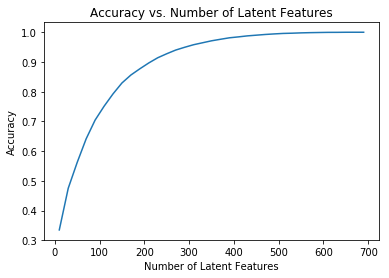

In [92]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

#We can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Instead, we will split our dataset into a training and test set of data.  

We will answer following questions as well:
* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [53]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # training dataframe
    user_item_train = create_user_item_matrix(df_train)

    # testing dataframe
    user_item_test = create_user_item_matrix(df_test)

    test_idx = list(user_item_train.index)  # test user ids
    test_arts = list(user_item_train.columns)  # test article ids
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [54]:
#How many movies can we make predictions for in the test set?
user_item_test.shape

(682, 574)

In [55]:
user_item_train.shape

(4487, 714)

In [56]:
#How many users in the test set are we not able to make predictions for because of the cold start problem?
len(np.setdiff1d(user_item_test.index, user_item_train.index))

662

In [57]:
#How many movies in the test set are we not able to make predictions for because of the cold start problem?
len(np.setdiff1d(user_item_test.columns, user_item_train.columns))

0

Now using the user_item_train dataset from above to find U, S, and V transpose using SVD. Then finding the subset of rows in the **user_item_test** dataset that can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

Using SVD recommendations on the test data.  

In [58]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [56]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [57]:
# Subset of rows in the user_item_test dataset that you can predict

#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

#  Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

In [58]:
# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

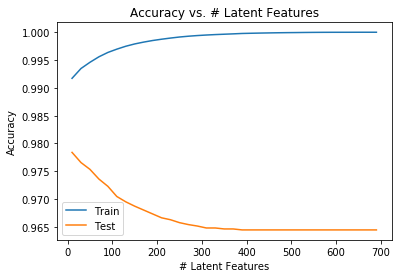

In [59]:
latent_features = np.arange(10, 700+10, 20)

train_errs, test_errs = [], []


for k in latent_features:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))


plt.figure()
plt.plot(latent_features, train_errs, label='Train')
plt.plot(latent_features, test_errs, label='Test')
plt.xlabel('# Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. # Latent Features')
plt.legend()
plt.show()

 **Results**
 
 Looking at above plot, we can see that test acccuracy is decreasing with the increase in latent factors and train accuracy is improving with number of latent features. This might be beause of overfitting. 
We can also see our results with such a higher accuracy because our problem is highly imbalanced between 1's and 0's.
The number of common users between train and test set are only 20, therefore our test results might not be representative of actual production results.


Apart from Offline approach of validating our recommendation system, we have use the online approach for testig our recommendation system. For an example, we can devide the customers into two groups where one set of users can get recommendations with our newly designed system and other set of users can get recommendations with our existing recommendation system which may be ranked based recommendation system. After conducting A/B test on above two groups, we can evaluate the performance of our recommendation system.